<a href="https://colab.research.google.com/github/nicolasbejar/Proyecto_Iris/blob/Andre/Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Function and modules for the supervised regression models

In [2]:
!pip install -q keras

In [3]:
import keras

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

Function and modules for data analysis and model evaluation


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

Function and modules for deep learning models

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

Function and modules for time series models

In [6]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Function and modules for data preparation and visualization

In [7]:
# pandas, pandas_datareader, numpy and matplotlib
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

 Cargando los datos

In [8]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK','DEXCHUS']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [9]:
print(stk_data)
print(ccy_data)
print(idx_data)

Attributes   Adj Close              ...     Volume           
Symbols           MSFT         IBM  ...        IBM      GOOGL
Date                                ...                      
2016-04-29   45.729378  117.030098  ...  4225800.0  2913900.0
2016-05-02   46.407951  116.492844  ...  3502400.0  1673800.0
2016-05-03   45.646847  115.578667  ...  3584300.0  1931000.0
2016-05-04   45.729378  115.674889  ...  2577100.0  1708600.0
2016-05-05   45.793564  117.455124  ...  6501200.0  1483400.0
...                ...         ...  ...        ...        ...
2021-04-22  257.170013  141.279999  ...  7101400.0  1207300.0
2021-04-23  261.149994  142.429993  ...  4556000.0  1453300.0
2021-04-26  261.549988  141.570007  ...  4710800.0  1601900.0
2021-04-27  261.970001  142.009995  ...  3880900.0  2202900.0
2021-04-28  253.919998  143.211197  ...  1408336.0  2479385.0

[1258 rows x 18 columns]
            DEXJPUS  DEXUSUK  DEXCHUS
DATE                                 
2016-04-29   106.90   1.4625  

A continuación, definimos nuestras variables dependientes (Y) e independientes (X) . La variable predicha es el rendimiento semanal de Microsoft (MSFT). Se supone que el número de días de negociación en una semana es cinco y calculamos el rendimiento utilizando cinco días de negociación. Para las variables independientes utilizamos los activos correlacionados y el rendimiento histórico de MSFT a diferentes frecuencias.

Las variables que se utilizan como variables independientes son el rendimiento de las acciones (IBM y GOOG) retrasado a cinco días, las divisas (USD / JPY y GBP / USD) y los índices (S&P 500, Dow Jones y VIX), junto con el retraso de cinco días. , Devolución de MSFT en 15, 30 y 60 días.

Las variables retrasadas de cinco días incorporan el componente de serie de tiempo mediante un enfoque de retraso temporal, donde la variable retrasada se incluye como una de las variables independientes. Este paso consiste en reformular los datos de la serie temporal en un marco de modelo basado en regresión supervisada.

Opción 1: Predecir retornos semanales: 5 días en bolsa

In [12]:
#Periodo de 5 día en bolsa
return_period = 5

#Variable predictora
#Sacar el los retornos logaritmincos
#.loc usado para extraer valores del dataframe
#
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).\
 shift(-return_period)
Y.name = Y.name[-1]+'_pred'

Y.name

#Variable independientes

#Activos correlacionados
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()

#Divisas y Indices
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

#
X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i)\
 for i in [return_period, return_period*3,\
return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

#Unión de varibles independientes
X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]


Opción 2: Predecir retornos de 1 día

In [10]:
#Periodo de 1 día en bolsa
return_period = 1

#Variable predictora
#Sacar el los retornos logaritmincos
#.loc usado para extraer valores del dataframe
#
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).\
 shift(-return_period)
Y.name = Y.name[-1]+'_pred'

Y.name

#Variable independientes

#Activos correlacionados
#Calcula retonso de las acciones correlacionadas
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()

#Divisas y Indices
#Calcular retonso de las divisas e indices
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

#Retornos historicos retradados. de la accióna predecir pero para difernetes tiempos anteriores
X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i)\
 for i in [return_period, return_period*3,\
return_period*6, return_period*12]], axis=1).dropna()

X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']


#Unión de varibles independientes
X = pd.concat([X1, X2, X3, X4], axis=1)


#Agrupara la info en el dataset
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

 ANÁLISIS DE DATOS EXPLORATORIOS


In [11]:
dataset.head()


,MSFT_pred,IBM,GOOGL,DEXJPUS,DEXUSUK,DEXCHUS,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2016-05-17,0.005922,-0.009816,-0.013940,0.001193,0.005122,-0.000215,-0.009456,-0.010257,0.058860,-0.018828,-0.012635,0.015719,0.019722
2016-05-18,-0.009691,-0.004470,0.002205,0.005762,0.008935,0.003064,0.000205,-0.000192,0.024113,0.005922,0.001670,0.002845,0.010914
2016-05-19,0.005944,-0.016492,-0.009004,0.001458,-0.000479,0.001070,-0.003714,-0.005218,0.023545,-0.009691,-0.022597,-0.007433,0.017759
2016-05-20,-0.011724,0.015881,0.008907,0.006445,-0.006525,0.000687,0.006001,0.003752,-0.071708,0.005944,0.002176,-0.010459,0.021897
2016-05-23,0.030705,-0.003265,-0.006199,-0.009546,-0.004766,0.000733,-0.002088,-0.000458,0.039980,-0.011724,-0.015470,-0.013800,0.008771


 Visualización de datos
 

Correlación de variables independientes: Algunos algoritmos tienen problemas si hay correlación entre variables.

Estos gráficos nos dan una idea de la interdependencia de los datos. La correlación se puede calcular y mostrar para cada par de variables creando una matriz de correlación. Por tanto, además de la relación entre variables independientes y dependientes, también muestra la correlación entre las variables independientes. Es útil saberlo porque algunos algoritmos de aprendizaje automático, como la regresión lineal y logística, pueden tener un rendimiento deficiente si hay variables de entrada altamente correlacionadas en los datos

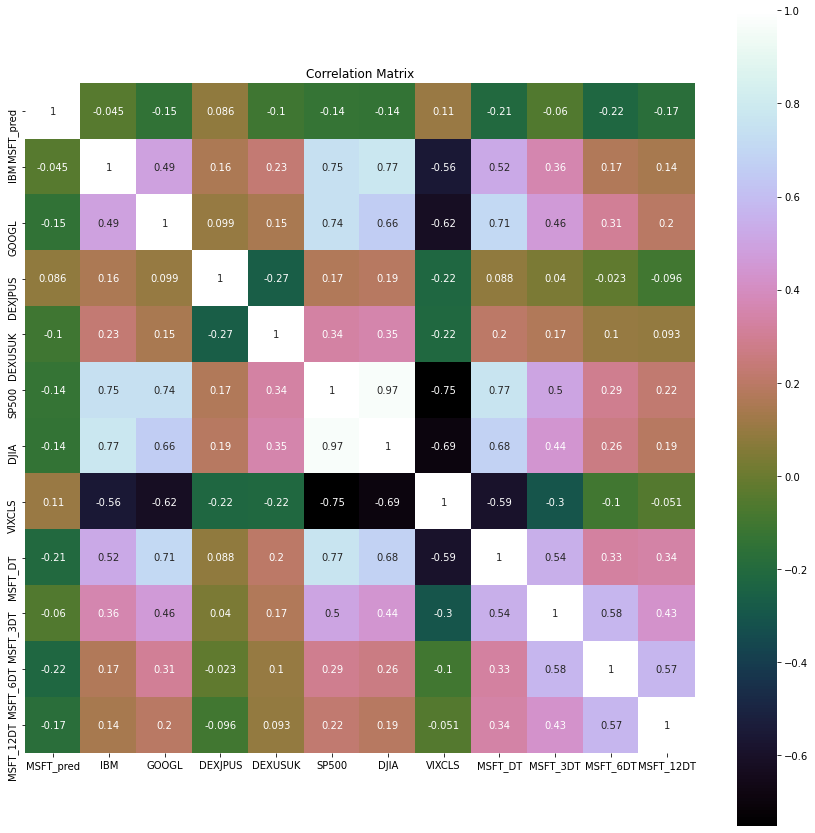

In [ ]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

A continuación, podemos visualizar la relación entre todas las variables en la regresión usando la matriz de diagrama de dispersión que se muestra a continuación.

Al observar el diagrama de dispersión, vemos alguna relación lineal de la variable predicha con los retornos retrasados ​​de 15 días, 30 días y 60 días de MSFT. De lo contrario, no vemos ninguna relación especial entre nuestra variable predicha y las características.

<Figure size 1080x1080 with 0 Axes>

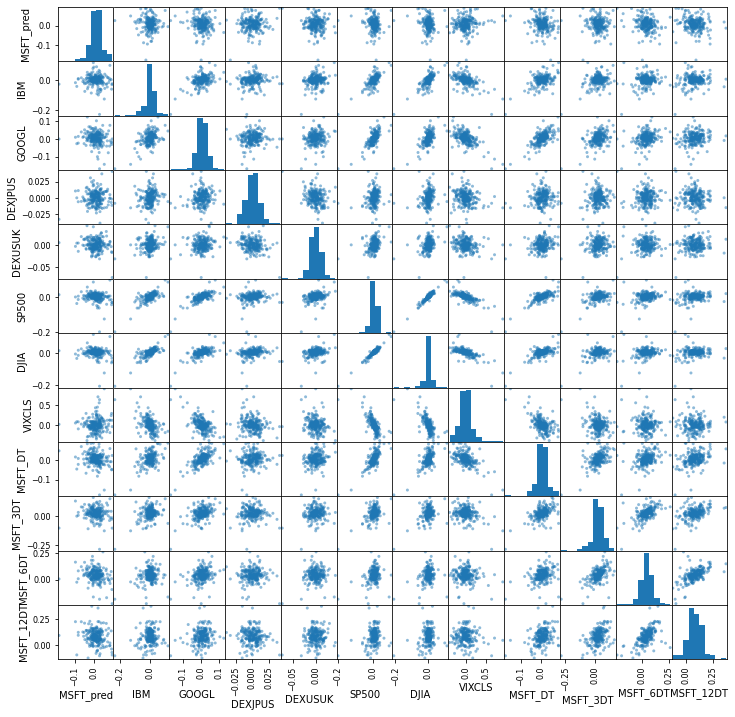

In [ ]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()


Análisis de series temporales

A continuación, profundizamos en el análisis de series de tiempo y observamos la descomposición de la serie de tiempo de la variable predicha en componentes de tendencia y estacionalidad:

Podemos ver que para MSFT ha habido una tendencia general al alza en la serie de retornos. Esto puede deberse al gran aumento de MSFT en los últimos años, lo que ha provocado más puntos de datos de rentabilidad semanal positivos que negativos. 11 La tendencia puede mostrarse en términos de constante / sesgo en nuestros modelos. El término residual (o ruido blanco) es relativamente pequeño en toda la serie de tiempo.

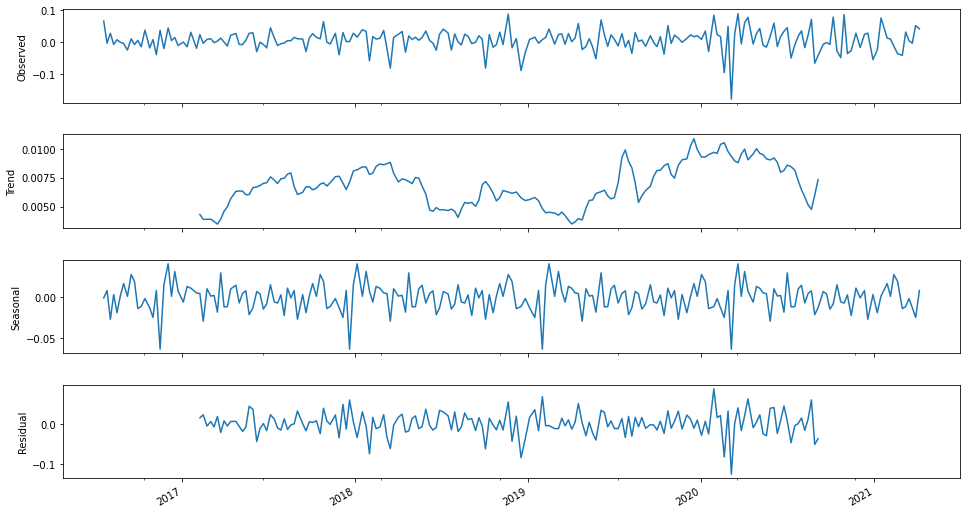

In [ ]:
res = sm.tsa.seasonal_decompose(Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

# **EVALUAR MODELOS APRENDIZAJE SUPERVISADO REGRESSION**

Los modelos utilizados incorporan el componente de series de tiempo utilizando un enfoque de retardo de tiempo, donde la variable rezagada se incluye como una de las variables independientes.

**Train-test split and evaluation metrics**


Usaremos el 80% del conjunto de datos para modelar y usaremos el 20% para pruebas. Con datos de series de tiempo, la secuencia de valores es importante. Por lo tanto, no distribuimos el conjunto de datos en conjuntos de entrenamiento y prueba de forma aleatoria, sino que seleccionamos un punto de división arbitrario en la lista ordenada de observaciones y creamos dos nuevos conjuntos de dato

In [12]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

**Opciones de prueba y métricas de evaluación**

Para optimizar los diversos hiperparámetros de los modelos, utilizamos la validación cruzada (CV) diez veces mayor y recalculamos los resultados diez veces para tener en cuenta la aleatoriedad inherente en algunos de los modelos y el proceso de CV

Evaluaremos algoritmos usando la métrica de error cuadrático medio. 

Esta métrica da una idea del desempeño de los modelos de regresión supervisados. Todos estos conceptos, incluidas las métricas de validación cruzada y evaluación

In [19]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

**Comparar modelos y algoritmos**

Modelos de aprendizaje automático de Scikit-learn
En este paso, los modelos de regresión supervisados ​​se implementan usando el paquete sklearn:


(1) **Modelos Regression and tree regression algorithms:**

Regresión lineal
Lasso: L1 regularization or Lasso regression, Regresión lineal regularizada
Elastic net: Regualrización de regresión con L1 y L2
K-nearest neighbors (KNN): No requiere entrenamiento
CART or decision tree classifiers
SVR: support vector machine


In [14]:
#Conjunto de modelos
models = []
#Modelos
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))


(2) **Modelo de Neural network algorithms**

In [15]:
models.append(('MLP', MLPRegressor()))


(3) **Ensemble models: Modelos ensamblados:**
El objetivo de los modelos de conjunto es combinar diferentes clasificadores en un metaclasificador que tenga un mejor rendimiento de generalización que cada clasificador individual solo

Tanto Boosting methods como Bagging methods.

Bagging es cuando paralelamente se evaluan varios modelos y luego se unen:
-Random forest
-EXTRA TREES

Boosting es cuando varios modelos se realizan secuencialmentes y se va mejorando el modelo:
-Adaptive Boosting
-Gradient boosting method (GBM)


In [16]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

**ENTRENAMIENTO**
**Recorrer cada uno de los modelos anteriores**

Una vez que hemos seleccionado todos los modelos, recorremos cada uno de ellos. Primero, ejecutamos el análisis de k- fold. A continuación, ejecutamos el modelo en todo el conjunto de datos de entrenamiento y prueba.

Todos los algoritmos utilizan parámetros de ajuste predeterminados. Calcularemos la media y la desviación estándar de la métrica de evaluación para cada algoritmo y recopilaremos los resultados para la comparación del modelo más adelante:

**K fold: **Consiste en dividir los datos de forma aleatoria en k grupos de aproximadamente el mismo tamaño, k-1 grupos se emplean para entrenar el modelo y uno de los grupos se emplea como validación. Este proceso se repite k veces utilizando un grupo distinto como validación en cada iteración. El proceso genera k estimaciones del error cuyo promedio se emplea como estimación final.

 Ajustar su modelo a (es decir, usar el .fit()método en) los datos de entrenamiento es esencialmente la parte de entrenamiento del proceso de modelado. Encuentra los coeficientes para la ecuación especificada mediante el algoritmo que se está utilizando

In [26]:
#Crear Variable de resultados
names = []
kfold_results = [] #Validación cruzada
test_results = []
train_results = []


for name, model in models:
    names.append(name)

    ## k-fold analysis:
    # K-fold: Validadción cruzada, num-folds es variable anteriormente asignada
    kfold = KFold(n_splits=num_folds, random_state=seed)

    #converted mean squared error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR: 0.000287 (0.000341) 0.000250 0.000345
LASSO: 0.000295 (0.000383) 0.000294 0.000323
EN: 0.000295 (0.000383) 0.000294 0.000323


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.000315 (0.000370) 0.000200 0.000358
CART: 0.000532 (0.000397) 0.000000 0.000646
SVR: 0.000492 (0.000334) 0.000478 0.000540


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


MLP: 0.000274 (0.000295) 0.000267 0.000330


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


ABR: 0.000310 (0.000357) 0.000184 0.000341


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


GBR: 0.000317 (0.000388) 0.000097 0.000347


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RFR: 0.000293 (0.000348) 0.000044 0.000353


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


ETR: 0.000301 (0.000369) 0.000000 0.000360


**K Fold results**

Comparemos los algoritmos observando los resultados de la validación cruzada: K:fold

Entre menor, es mejor!!!


Aunque los resultados de un par de modelos parecen buenos, vemos que la regresión lineal y la regresión regularizada, incluida la regresión de lazo (LASSO) y la red elástica (EN), parecen funcionar mejor. Esto indica una fuerte relación lineal entre las variables dependientes e independientes. 

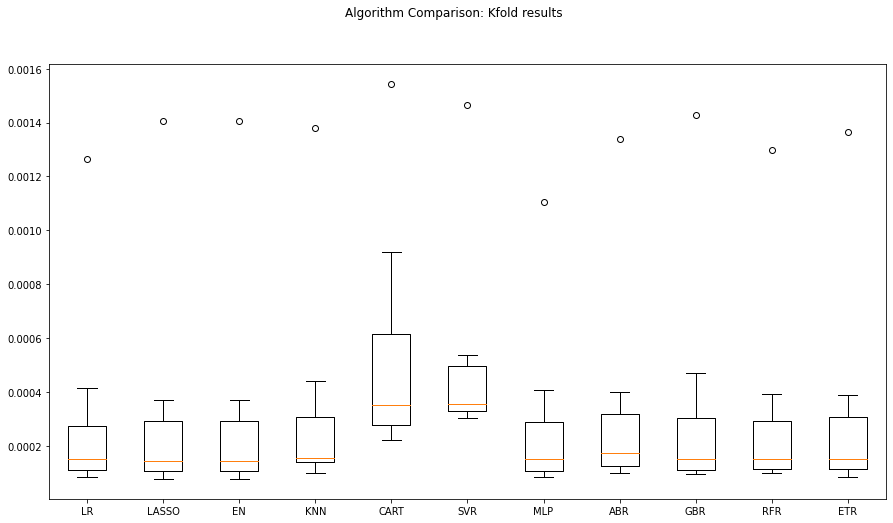

In [34]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

**Training and Test error**

Comparar los errores del conjunto de prueba:

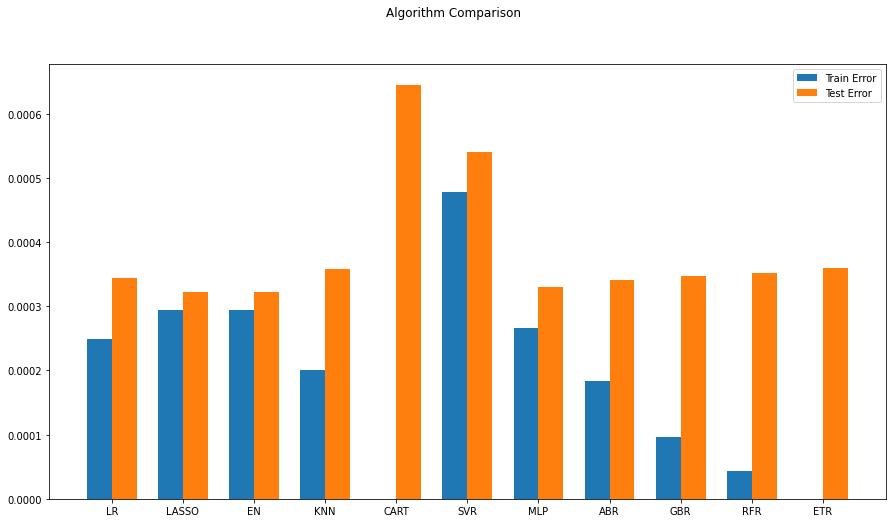

In [37]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')

fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Al examinar el error de entrenamiento y prueba, todavía vemos un rendimiento más fuerte de los modelos lineales. Algunos de los algoritmos, como el regresor del árbol de decisión (CART), se ajustan en exceso a los datos de entrenamiento y producen un error muy alto en el conjunto de prueba. Los modelos de conjunto, como la regresión de aumento de gradiente (GBR) y la regresión de bosque aleatorio (RFR), tienen un sesgo bajo pero una alta varianza. También vemos que el algoritmo de red neuronal artificial (que se muestra como MLP en el gráfico) muestra errores más altos tanto en el entrenamiento como en los conjuntos de prueba. Esto quizás se deba a la relación lineal de las variables no capturadas con precisión por ANN, hiperparámetros inadecuados o entrenamiento insuficiente del modelo. Nuestra intuición original de los resultados de la validación cruzada y los diagramas de dispersión también parecen demostrar un mejor rendimiento de los modelos lineales.

# **Otros modelos de series de tiempo: Arima y LSTM**

Ahora analizamos algunas de las series de tiempo y modelos de aprendizaje profundo que se pueden utilizar. Una vez que hayamos terminado de crearlos, compararemos su desempeño con el de los modelos basados ​​en regresión supervisada. Debido a la naturaleza de los modelos de series de tiempo, no podemos ejecutar un análisis de k- veces. Aún podemos comparar nuestros resultados con los otros modelos en función de los resultados completos de las pruebas y el entrenamiento.

**Modelo ARIMA**

Primero preparemos el conjunto de datos para los modelos ARIMA teniendo solo las variables correlacionadas como variables exógenas:

In [38]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

El modelo ARIMA se representa generalmente como modelo ARIMA (p, d, q) , donde p es el orden de la parte autorregresiva, d es el grado de primera diferenciación involucrado yq es el orden de la parte de media móvil. El orden del modelo ARIMA se estableció en (1,0,0) 

Ahora configuramos el modelo ARIMA con el orden (1,0,0) y usamos las variables independientes como variables exógenas en el modelo. La versión del modelo ARIMA donde también se utilizan las variables exógenas se conoce como modelo ARIMAX , donde " X " representa las variables exógenas:

In [39]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Ahora encajamos el modelo ARIMA: Errores del  modelo de entrenamiento y prueba:

In [40]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, \
  exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


0.00033776725113219674

**Modelo LSTM: RNN: Deep Learning**

La lógica detrás del LSTM es que los datos se toman del día anterior (los datos de todas las demás características de ese día, los activos correlacionados y las variables rezagadas de MSFT) y tratamos de predecir el día siguiente. Luego, movemos la ventana de un día con un día y nuevamente predecimos el día siguiente. Repetimos así en todo el conjunto de datos (por supuesto, en lotes)

Ahora preparemos el conjunto de datos para el modelo LSTM. Necesitamos los datos en forma de matrices de todas las variables de entrada y las variables de salida.

El siguiente código creará un conjunto de datos en el que X es el conjunto de variables independientes en un momento dado ( t ) e Y es la variable objetivo en el siguiente momento ( t + 1 ):